In [1]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
%cd /usr/local/

!rm -rf cuda

!ln -s /usr/local/cuda-10.1 /usr/local/cuda

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-2jooov9j
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-2jooov9j
directory /content/src already exists
Out bin /content/result.out
/usr/local


In [2]:
!stat cuda

!nvidia-smi

  File: cuda -> /usr/local/cuda-10.1
  Size: 20        	Blocks: 0          IO Block: 4096   symbolic link
Device: 24h/36d	Inode: 3145740     Links: 1
Access: (0777/lrwxrwxrwx)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2022-02-03 19:27:41.927961169 +0000
Modify: 2022-02-03 19:27:41.815954181 +0000
Change: 2022-02-03 19:27:41.815954181 +0000
 Birth: -
Thu Feb  3 19:27:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:

### Poniżej jest cudaMalloc

In [3]:
%%writefile test.cu
#include <cuda_runtime_api.h>
#include <cstdlib>
#include <iostream>
#include <fstream>
#include <string>
#include <time.h>


__device__ 
int getAgent(int x, int y, int width, int* cudaBoard) {
    return cudaBoard[y*width+x];
}

__device__
int calculateNeighbours(int x, int y, int width, int height, int *cudaBoard) {
    int n = 0;

    n += getAgent((x+width-1)%width, (y+height-1)%height, width, cudaBoard); // x-1, y-1
    n += getAgent(x, (y+height-1)%height, width, cudaBoard);                 // x,   y-1
    n += getAgent((x+1)%width, (y+height-1)%height, width, cudaBoard);       // x+1, y-1

    n += getAgent((x+width-1)%width, y, width, cudaBoard);                   // x-1, y
    n += getAgent((x+1)%width, y, width, cudaBoard);                         // x+1, y

    n += getAgent((x+width-1)%width, (y+1)%height, width, cudaBoard);        // x-1, y+1
    n += getAgent(x, (y+1)%height, width, cudaBoard);                        // x,   y+1
    n += getAgent((x+1)%width, (y+1)%height, width, cudaBoard);              // x+1, y+1

    return n;
}

__global__
void runGeneration(int width, int height, int *cudaBoardOld, int *cudaBoardNew) {
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    for(int i=index; i < width*height; i += stride) {
        int x = i%width;
        int y = i/width;

        int state = cudaBoardOld[i];
        int neighbours = calculateNeighbours(x, y, width, height, cudaBoardOld);
        
        
        if(state == 0 && neighbours == 3) {
            cudaBoardNew[i] = 1;
            continue;
        }
        if(state == 1 && (!(neighbours == 2 || neighbours == 3))) {
            cudaBoardNew[i] = 0;
            continue;
        }
        cudaBoardNew[i] = cudaBoardOld[i];
    }
}


void initializeBoard(int width, int height, int *board) {
    for(int i=0; i<width*height; ++i) 
        board[i] = rand() % 2;
}

void saveBoard(std::string name, int *localBoard, int width, int height) {
    std::ofstream MyFile(name);

    for(int x=0; x<width; ++x) {
        for(int y=0; y<height; ++y) {
            if(y != height-1)
                MyFile << localBoard[y*width+x] << ", ";
            else
                MyFile << localBoard[y*width+x];
        }
        MyFile << "\n";
    }

    MyFile.close();
}

int main(int argc, char** argv) {
    srand (time(NULL));
    int width = atoi(argv[2]);
    int height = atoi(argv[3]);
    int generations = atoi(argv[1]);
    int *cudaBoardOld, *cudaBoardNew, *localBoard;

    localBoard = new int[width*height];
    initializeBoard(width, height, localBoard);

    saveBoard("start.txt", localBoard, width, height);
    
    cudaMalloc(&cudaBoardOld, width*height*sizeof(int));
    cudaMalloc(&cudaBoardNew, width*height*sizeof(int));
    cudaMemcpy(cudaBoardOld, localBoard, width*height*sizeof(int), cudaMemcpyHostToDevice);

    int blockSize = 256;
    int numBlocks = (width*height + blockSize - 1) / blockSize;

    for(int i=0; i<generations; ++i) {
        runGeneration<<<numBlocks, blockSize>>>(width, height, cudaBoardOld, cudaBoardNew);
        cudaDeviceSynchronize();
        
        int *temp = cudaBoardOld;
        cudaBoardOld = cudaBoardNew;
        cudaBoardNew = temp;
    }

    cudaMemcpy(localBoard, cudaBoardOld, width*height*sizeof(int), cudaMemcpyDeviceToHost);

    saveBoard("end.txt", localBoard, width, height);
    

    cudaFree(cudaBoardOld);
    cudaFree(cudaBoardNew);
    delete[] localBoard;

    return 0;
}

Overwriting test.cu


In [4]:
%%bash

nvcc --std=c++11 test.cu -o test

In [5]:
%%bash
./test 100000 200 200

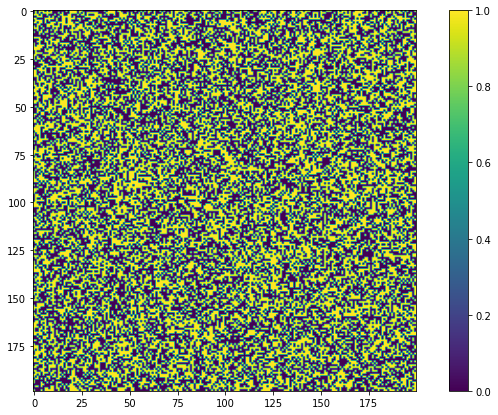

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('start.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

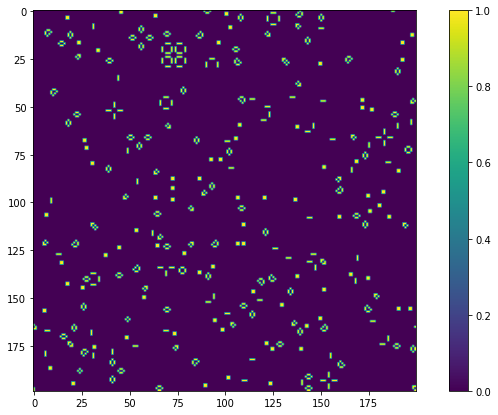

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('end.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

In [8]:
%%bash

nvprof ./test 100000 200 200

==1132== NVPROF is profiling process 1132, command: ./test 100000 200 200
==1132== Profiling application: ./test 100000 200 200
==1132== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   99.99%  409.76ms    100000  4.0970us  2.9440us  5.2480us  runGeneration(int, int, int*, int*)
                    0.00%  15.584us         1  15.584us  15.584us  15.584us  [CUDA memcpy HtoD]
                    0.00%  14.367us         1  14.367us  14.367us  14.367us  [CUDA memcpy DtoH]
      API calls:   50.17%  775.89ms    100000  7.7580us  1.7860us  202.66us  cudaDeviceSynchronize
                   31.43%  486.01ms    100000  4.8600us  3.9620us  191.38us  cudaLaunchKernel
                   18.33%  283.45ms         2  141.73ms  4.0560us  283.45ms  cudaMalloc
                    0.03%  456.60us         1  456.60us  456.60us  456.60us  cuDeviceTotalMem
                    0.01%  221.48us         2  110.74us  35.252us  186.23us  cudaFr

### Poniżej jest cudaMallocHost

In [9]:
%%writefile test2.cu
#include <cuda_runtime_api.h>
#include <cstdlib>
#include <iostream>
#include <fstream>
#include <string>
#include <time.h>


__device__ 
int getAgent(int x, int y, int width, int* cudaBoard) {
    return cudaBoard[y*width+x];
}

__device__
int calculateNeighbours(int x, int y, int width, int height, int *cudaBoard) {
    int n = 0;

    n += getAgent((x+width-1)%width, (y+height-1)%height, width, cudaBoard); // x-1, y-1
    n += getAgent(x, (y+height-1)%height, width, cudaBoard);                 // x,   y-1
    n += getAgent((x+1)%width, (y+height-1)%height, width, cudaBoard);       // x+1, y-1

    n += getAgent((x+width-1)%width, y, width, cudaBoard);                   // x-1, y
    n += getAgent((x+1)%width, y, width, cudaBoard);                         // x+1, y

    n += getAgent((x+width-1)%width, (y+1)%height, width, cudaBoard);        // x-1, y+1
    n += getAgent(x, (y+1)%height, width, cudaBoard);                        // x,   y+1
    n += getAgent((x+1)%width, (y+1)%height, width, cudaBoard);              // x+1, y+1

    return n;
}

__global__
void runGeneration(int width, int height, int *cudaBoardOld, int *cudaBoardNew) {
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    for(int i=index; i < width*height; i += stride) {
        int x = i%width;
        int y = i/width;

        int state = cudaBoardOld[i];
        int neighbours = calculateNeighbours(x, y, width, height, cudaBoardOld);
        
        
        if(state == 0 && neighbours == 3) {
            cudaBoardNew[i] = 1;
            continue;
        }
        if(state == 1 && (!(neighbours == 2 || neighbours == 3))) {
            cudaBoardNew[i] = 0;
            continue;
        }
        cudaBoardNew[i] = cudaBoardOld[i];
    }
}


void initializeBoard(int width, int height, int *board) {
    for(int i=0; i<width*height; ++i) 
        board[i] = rand() % 2;
}

void saveBoard(std::string name, int *localBoard, int width, int height) {
    std::ofstream MyFile(name);

    for(int x=0; x<width; ++x) {
        for(int y=0; y<height; ++y) {
            if(y != height-1)
                MyFile << localBoard[y*width+x] << ", ";
            else
                MyFile << localBoard[y*width+x];
        }
        MyFile << "\n";
    }

    MyFile.close();
}

int main(int argc, char** argv) {
    srand (time(NULL));
    int width = atoi(argv[2]);
    int height = atoi(argv[3]);
    int generations = atoi(argv[1]);
    int *cudaBoardOld, *cudaBoardNew, *localBoard;

    localBoard = new int[width*height];
    initializeBoard(width, height, localBoard);

    saveBoard("start2.txt", localBoard, width, height);
    
    cudaMallocHost(&cudaBoardOld, width*height*sizeof(int));
    cudaMallocHost(&cudaBoardNew, width*height*sizeof(int));
    cudaMemcpy(cudaBoardOld, localBoard, width*height*sizeof(int), cudaMemcpyHostToDevice);

    int blockSize = 256;
    int numBlocks = (width*height + blockSize - 1) / blockSize;

    for(int i=0; i<generations; ++i) {
        runGeneration<<<numBlocks, blockSize>>>(width, height, cudaBoardOld, cudaBoardNew);
        cudaDeviceSynchronize();
        
        int *temp = cudaBoardOld;
        cudaBoardOld = cudaBoardNew;
        cudaBoardNew = temp;
    }

    cudaMemcpy(localBoard, cudaBoardOld, width*height*sizeof(int), cudaMemcpyDeviceToHost);

    saveBoard("end2.txt", localBoard, width, height);
    

    cudaFree(cudaBoardOld);
    cudaFree(cudaBoardNew);
    delete[] localBoard;

    return 0;
}

Overwriting test2.cu


In [10]:
%%bash

nvcc --std=c++11 test2.cu -o test2

In [11]:
%%bash
./test2 100000 200 200

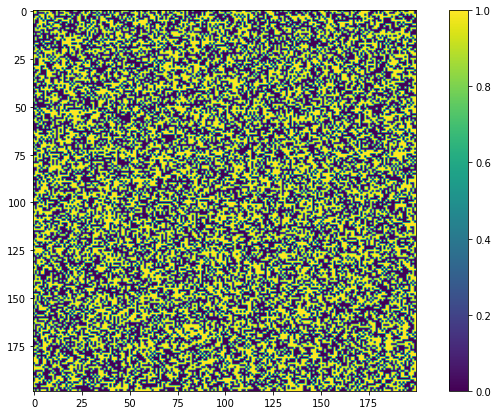

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('start2.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

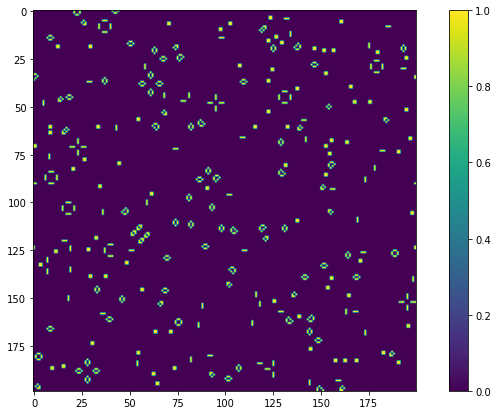

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('end2.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

In [14]:
%%bash

nvprof ./test2 100000 200 200

==1193== NVPROF is profiling process 1193, command: ./test2 100000 200 200
==1193== Profiling application: ./test2 100000 200 200
==1193== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  4.37669s    100000  43.766us  42.335us  78.974us  runGeneration(int, int, int*, int*)
                    0.00%  96.687us         2  48.343us  45.431us  51.256us  [CUDA memcpy HtoH]
      API calls:   84.65%  4.68662s    100000  46.866us  2.8320us  1.7883ms  cudaDeviceSynchronize
                    8.81%  487.66ms    100000  4.8760us  3.8730us  271.61us  cudaLaunchKernel
                    6.52%  361.11ms         2  180.56ms  9.3620us  361.10ms  cudaHostAlloc
                    0.01%  527.11us         1  527.11us  527.11us  527.11us  cuDeviceTotalMem
                    0.00%  229.40us        97  2.3640us     162ns  92.456us  cuDeviceGetAttribute
                    0.00%  122.47us         2  61.236us  57.579us  64.893us 